<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

3    3343
4    2003
1    1984
5    1934
0    1781
2    1287
6    1004
Name: state, dtype: int64

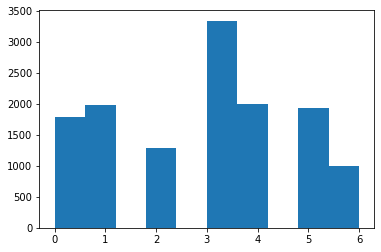

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 11, 24),
 datetime.date(2022, 11, 12),
 datetime.date(2012, 11, 14),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 11, 24), datetime.date(2022, 11, 12))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/(n - 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_41042/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_41042/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_41042/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_41042/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000295,0.995330,1.000889,1.000413,1.001276,1.001734,1.001968,1.018923
AA,1.000265,0.994075,1.000765,1.001096,1.001385,1.000974,1.001373,1.000866
AAIC,0.999505,0.992832,1.001126,1.000107,1.001438,1.001037,0.999996,1.019234
AAL,0.999953,0.993511,0.999613,1.002933,1.000941,1.000264,1.002030,1.025110
AAME,0.999987,0.996255,1.000112,1.001183,1.000554,1.001037,1.000071,1.001641


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000541,0.998145,0.998123,0.999655,1.005320,1.002437,0.998594,1.034292
ZTR,1.000192,0.998310,1.000180,1.000274,1.000655,1.000627,1.000724,1.001146
ZUMZ,1.000142,0.995358,0.999963,1.001651,1.000369,1.001183,1.001758,1.003438
ZWS,1.000071,0.992746,1.001254,0.997106,1.001175,1.001857,1.001613,1.024383
ZYXI,1.000492,0.998060,1.001444,1.001063,1.000158,0.998034,1.002926,1.021861


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

1

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar)
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.3*df[f'dar_{CURRENT_STATE}']
        + 0.5*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001286,0.997809,1.009395,0.996780,1.000388,1.001819,1.000996,0.986687,1.005353
GGE,1.000726,0.993479,1.006872,0.999278,1.002801,1.001850,0.999849,0.975423,1.003544
LFMD,1.000430,0.997794,1.004927,0.998066,1.002514,0.999358,0.999152,0.994627,1.002628
DTST,1.000531,0.998501,1.002991,1.006583,0.995846,1.000195,1.000242,1.048583,1.002409
ENPH,1.001379,0.991984,1.005141,0.997557,1.000329,1.004013,1.003533,1.012491,1.002315


In [32]:
df.mean(), df.median()

(dar         1.000171
 dar_0       0.996340
 dar_1       1.000356
 dar_2       1.000665
 dar_3       1.000994
 dar_4       1.001092
 dar_5       1.000957
 dar_6       1.009630
 weighted    0.999947
 dtype: float64,
 dar         1.000262
 dar_0       0.996512
 dar_1       1.000428
 dar_2       1.000691
 dar_3       1.001003
 dar_4       1.001078
 dar_5       1.000948
 dar_6       1.007748
 weighted    1.000095
 dtype: float64)

In [66]:
exclude = {
    0: ['AMEH', 'APT', 'ESOA', 'FSI', 'GME', 'WTRG'],
    1: ['DTST', 'FSI', 'MOBQ'],
    7: ['ELC']}

In [67]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]

In [68]:
print(sorted(best_weighted))

['AMRC', 'AMZN', 'CF', 'CHEF', 'COOP', 'CSIQ', 'CTSH', 'CVE', 'DQ', 'ELC', 'ENPH', 'FKWL', 'GGE', 'HBM', 'LFMD', 'NTAP', 'PACB', 'PAYS', 'RFP', 'TSLA']


In [69]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001286,0.997809,1.009395,0.996780,1.000388,1.001819,1.000996,0.986687,1.005353
GGE,1.000726,0.993479,1.006872,0.999278,1.002801,1.001850,0.999849,0.975423,1.003544
LFMD,1.000430,0.997794,1.004927,0.998066,1.002514,0.999358,0.999152,0.994627,1.002628
ENPH,1.001379,0.991984,1.005141,0.997557,1.000329,1.004013,1.003533,1.012491,1.002315
COOP,1.000485,0.995251,1.004011,0.999387,1.002085,1.001148,0.999331,1.022397,1.001967
AMRC,1.000579,0.992567,1.004239,0.999656,1.001283,1.001280,1.001913,1.028324,1.001881
PACB,0.999844,0.988819,1.005282,0.997919,1.000943,1.002710,1.000417,1.027946,1.001812
CVE,1.001499,0.995698,1.000980,1.013098,0.999232,1.000954,1.000012,1.027625,1.001767
RFP,1.000058,0.992125,1.003784,1.001889,0.999080,0.999907,1.002174,1.020573,1.001684
CSIQ,1.000192,0.990418,1.004424,0.998352,1.002326,1.003148,1.000888,1.020067,1.001570


In [70]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [71]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMRC,AMZN,CF,CHEF,COOP,CSIQ,CTSH,CVE,DQ,ELC,ENPH,FKWL,GGE,HBM,LFMD,NTAP,PACB,PAYS,RFP,TSLA
Date,,,,,,,,,,,,,,,,,,,,
2022-11-07,53.000000,90.529999,104.309998,37.930000,42.560001,32.439999,53.750000,21.180000,51.099998,0.55,268.829987,3.33,2.29,4.89,2.09,69.389999,8.42,2.36,21.000000,197.080002
2022-11-08,55.720001,89.980003,108.650002,37.480000,43.310001,34.630001,53.220001,21.330000,52.299999,0.55,280.070007,3.35,2.40,5.08,2.07,69.440002,9.03,2.45,21.000000,191.300003
2022-11-09,NaN,86.139999,NaN,NaN,42.259998,NaN,54.020000,20.000000,NaN,0.55,284.750000,NaN,NaN,NaN,2.01,NaN,8.34,NaN,NaN,177.589996
2022-11-10,61.939999,96.629997,108.489998,37.490002,43.150002,37.020000,57.290001,20.870001,55.669998,0.53,309.250000,3.33,2.58,5.26,2.08,71.910004,10.02,2.40,21.020000,190.720001
2022-11-11,61.160000,100.790001,102.820000,36.720001,42.990002,36.180000,58.419998,21.610001,55.709999,21.91,292.010010,3.34,2.85,5.46,2.48,73.500000,10.30,2.57,21.110001,195.970001


In [72]:
data = pd.concat([data, states], axis=1)

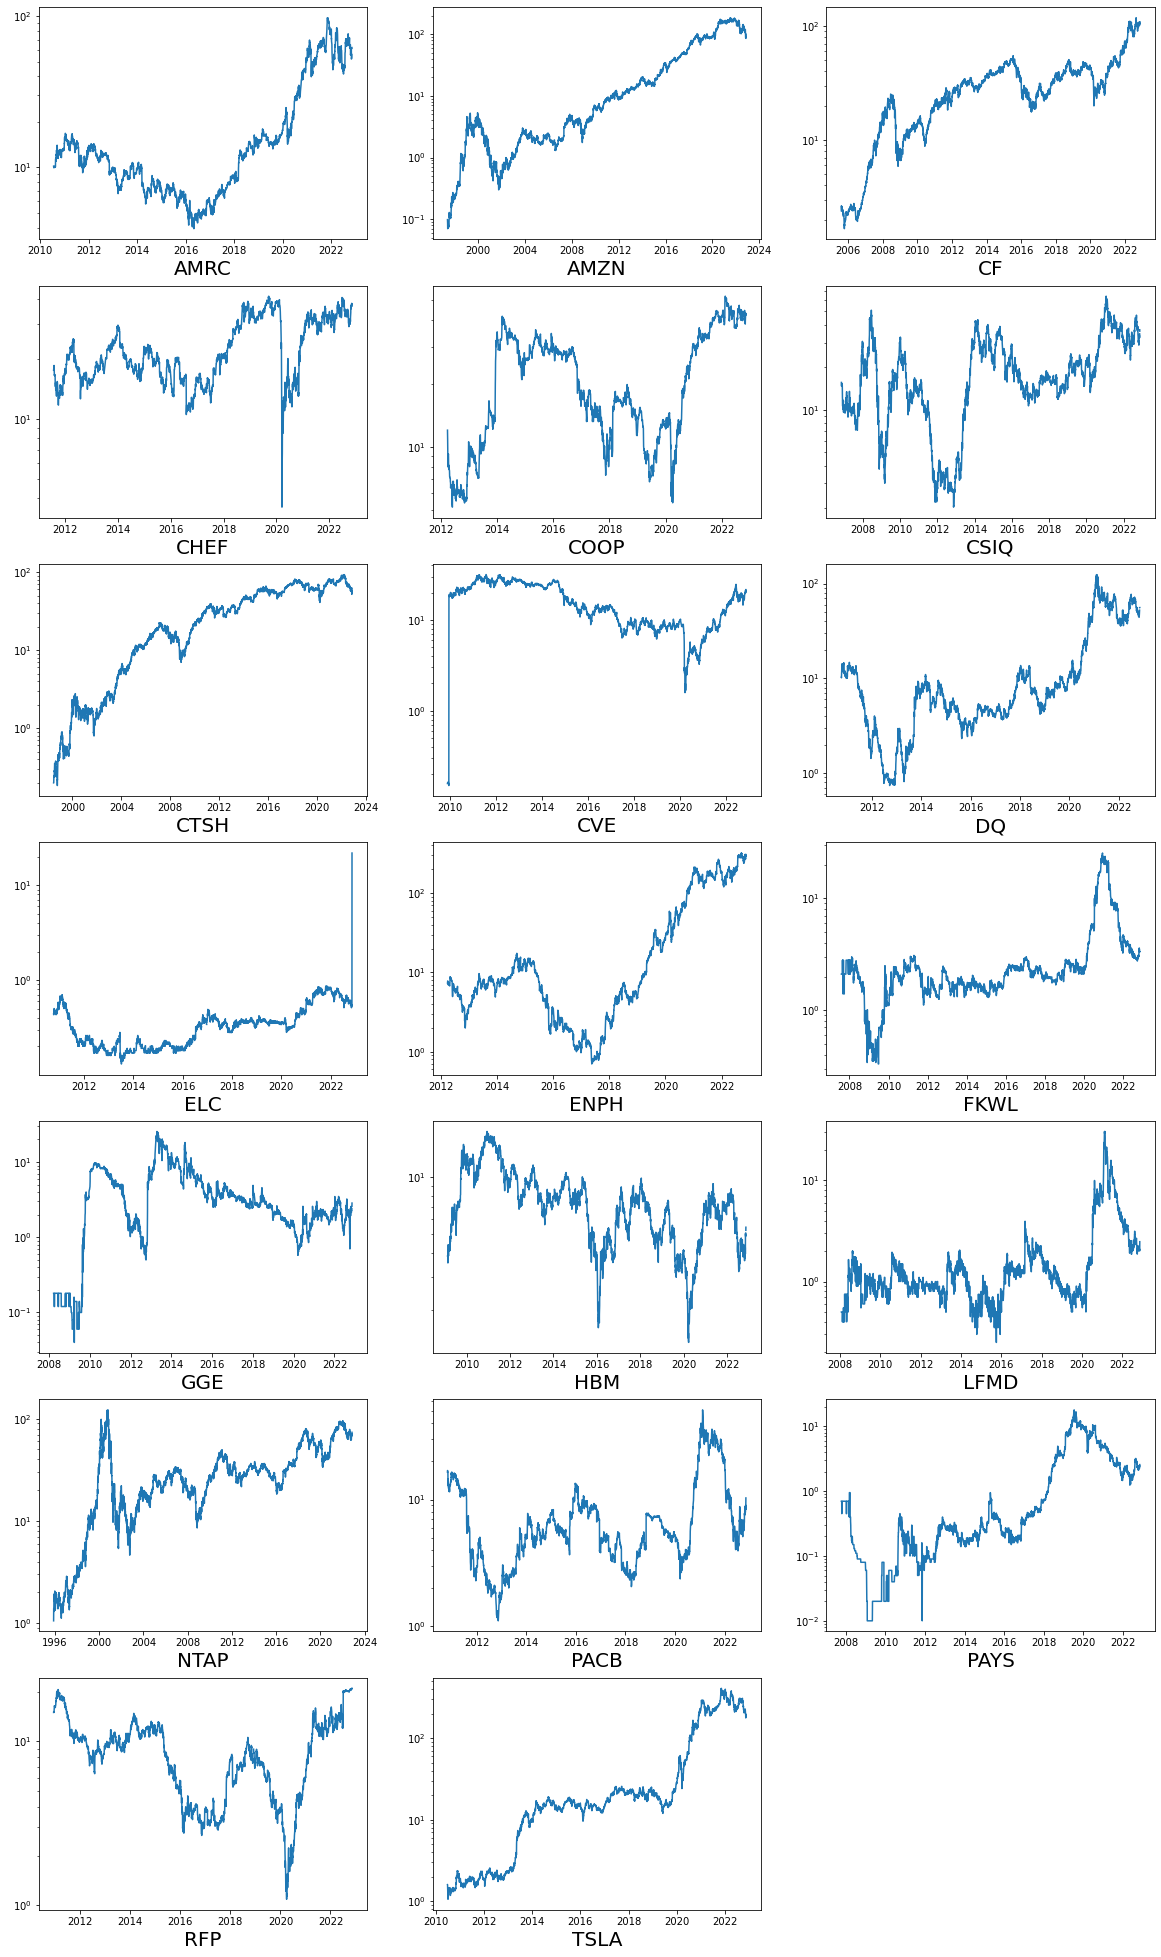

In [73]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

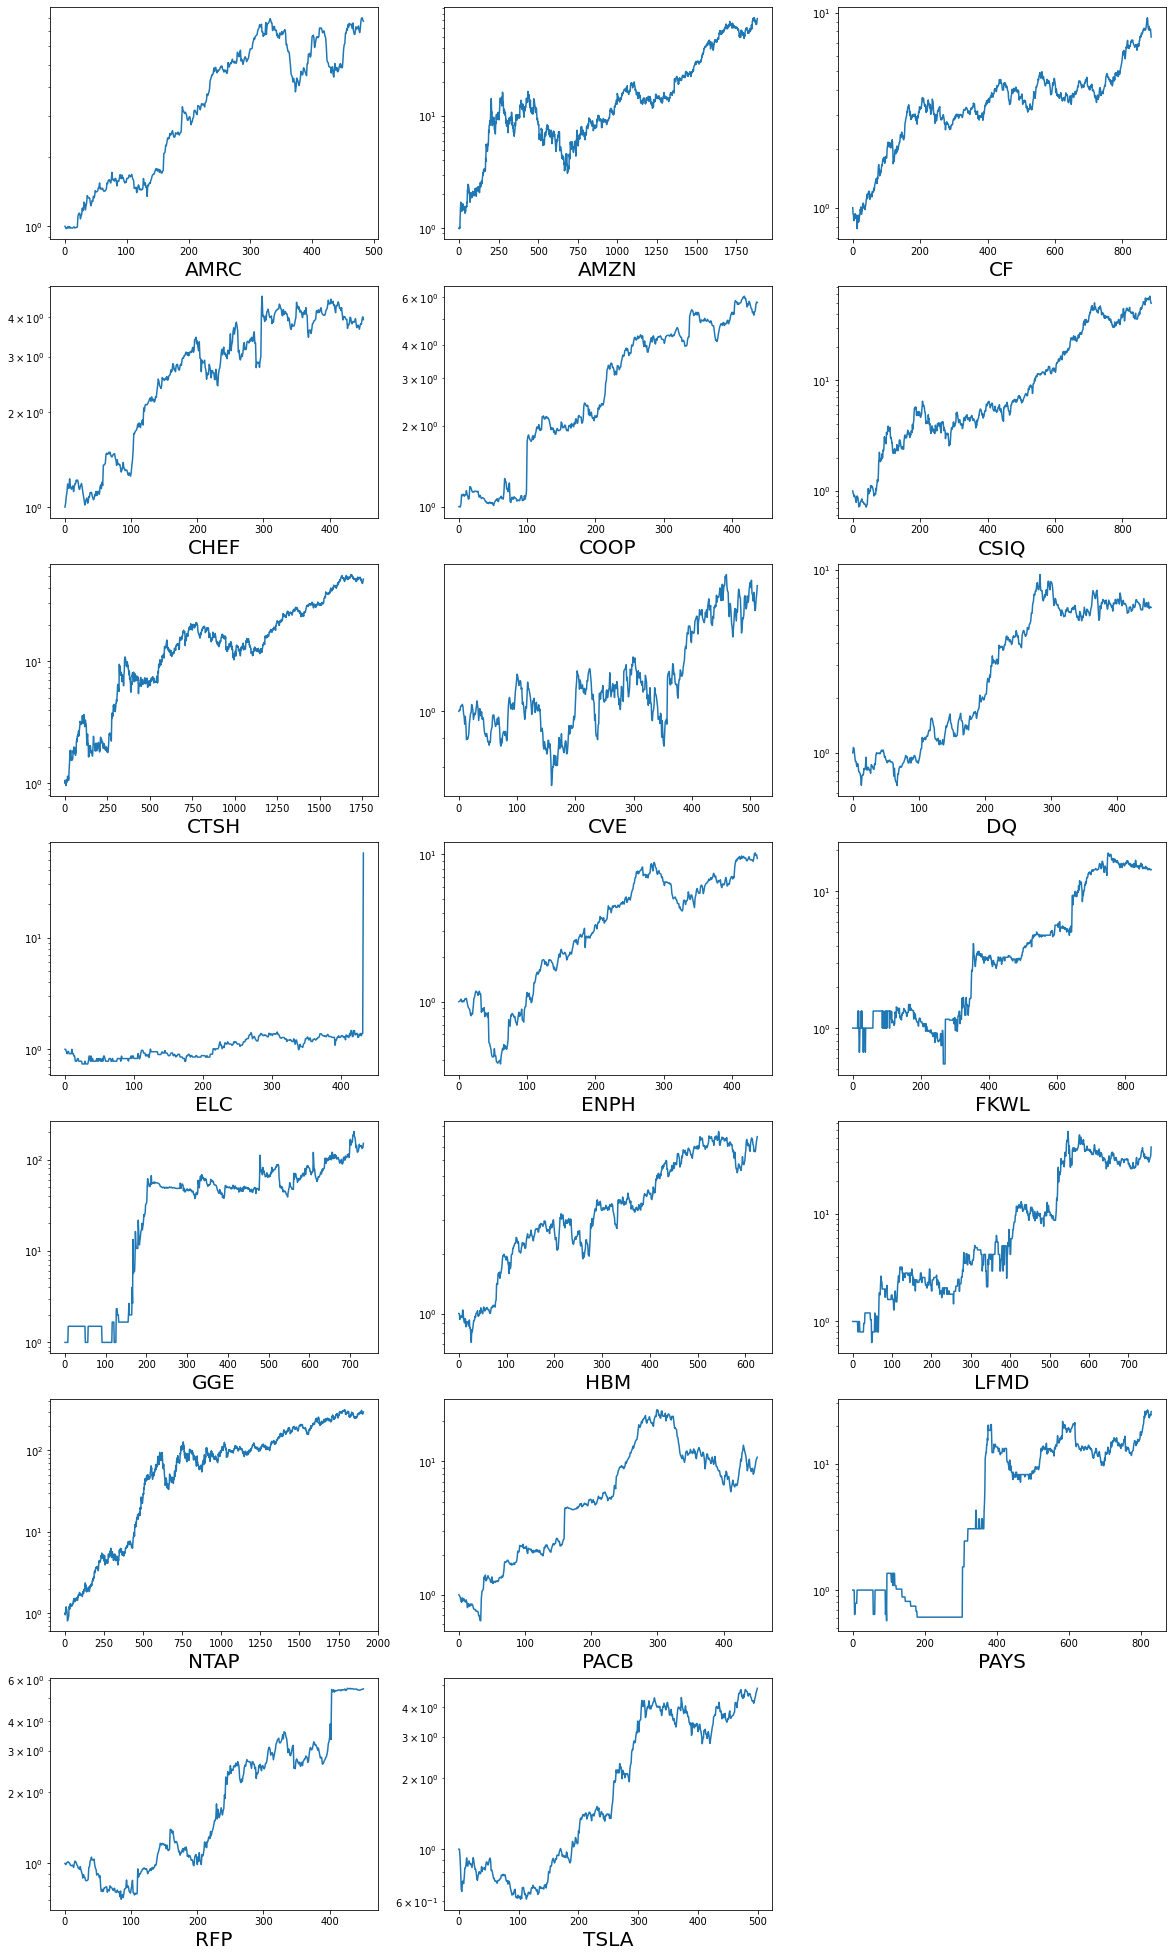

In [74]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);

In [54]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()